In [28]:
import pandas as pd
import numpy as np
np.random.seed(0)
from scipy.stats import beta as sp_beta

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 20, 13
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 2
import seaborn as sns

import sys
sys.path.insert(0, '../../..')
import assignment
import leximin_assignment
import matrix_gen
import kde_utils

from tqdm import tqdm

import warnings

In [3]:
df = pd.read_csv('../../../data/data.csv', index_col=0)
types = ['ES', 'TH', 'RRH', 'PREV']
df = df[df['Real'] != 2]
df = df.drop(labels='PSH', axis=1)

data = df[types].to_numpy().flatten()
kde = kde_utils.KDEHelper(np.log(data) - np.log(1 - data))

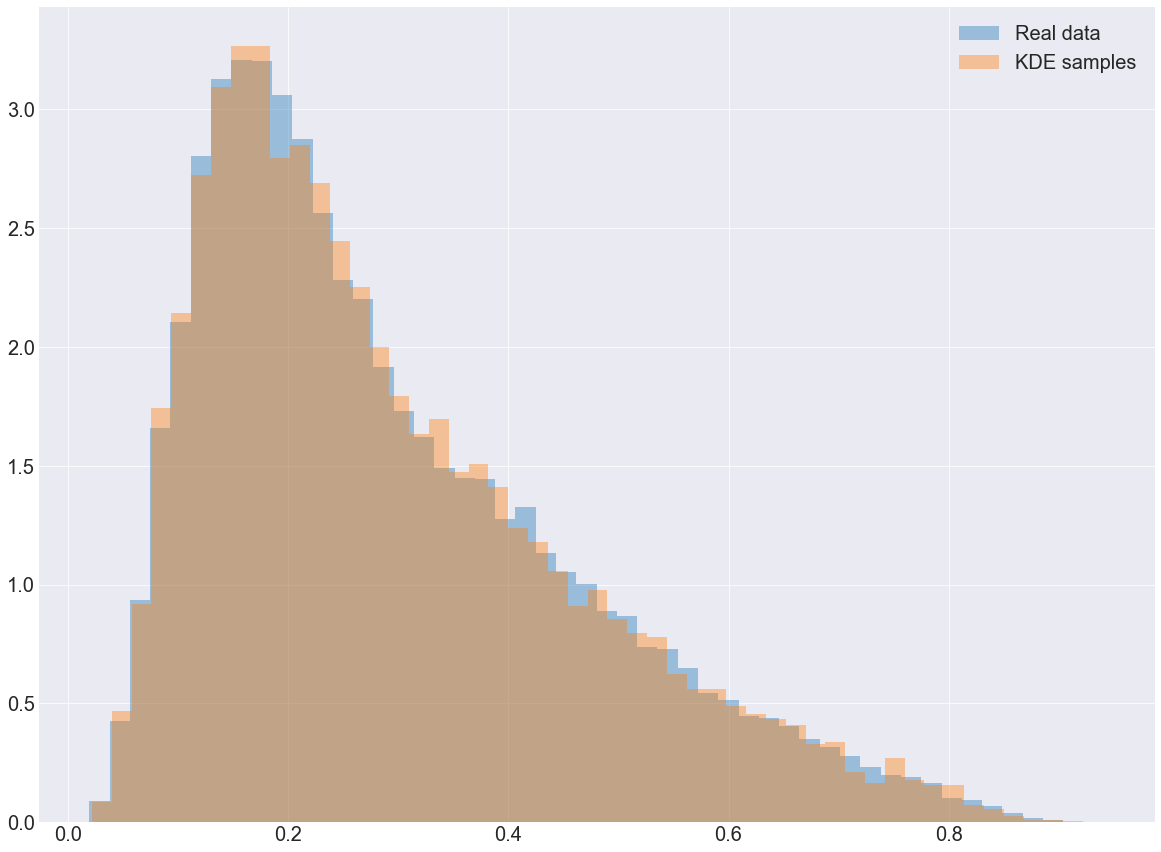

In [7]:
kde_samples = kde.sample_and_transform(size=(10000, 1))

plt.hist(data, alpha=0.4, label='Real data', density=True, bins=50)
plt.hist(kde_samples, alpha=0.4, label='KDE samples', density=True, bins=50)

plt.legend()
plt.show()

In [8]:
distributions = [
    np.random.uniform,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    kde.sample_and_transform
]

dist_params = [
    (0, 1),
    (1, 6),
    (6, 1),
    (2, 5),
    (5, 2),
    (0.5, 0.5),
    (0.6, 0.1),
    (0.1, 0.6),
    (lambda x: 1 / (1 + np.exp(-x)), None)
]

matrix_generators = [
    matrix_gen.MatrixGenerator(dist, params, N, N_INTVS)
    for dist, params in zip(distributions, dist_params)
]

labels = [
    f'{dist.__name__}({params[0]}, {params[1]})'
    for dist, params in zip(distributions, dist_params)
]
labels[-1] = 'KDE'

labels

['uniform(0, 1)',
 'beta(1, 6)',
 'beta(6, 1)',
 'beta(2, 5)',
 'beta(5, 2)',
 'beta(0.5, 0.5)',
 'beta(0.6, 0.1)',
 'beta(0.1, 0.6)',
 'KDE']

In [30]:
N = 30
N_INTVS = 5
N_EXPERIMENTS = 500  # 10 and 500

CAPACITIES = np.ones((N_INTVS,), dtype=int) * (N // N_INTVS)

In [31]:
limit = N_EXPERIMENTS * 2 * len(labels)

pof_df = pd.DataFrame(columns=[
    'PoF', 'Source', 'Sorted'
])

while pof_df.shape[0] < limit:
    temp_row = []
    # move_on = False
    
    # for matrix_generator in matrix_generators:
    success_count = 0
    while success_count < len(labels):
        print(pof_df.shape[0], '/', limit)
        print(success_count)
        
        (matrix, sorted_matrix), (increase_matrix, sorted_increase_matrix) = matrix_generators[success_count].get_increase_matrix_pair()
        
        
        
        ### Leximin
        lex_costs = []
        
        # Original matrix
        lex_assigner = leximin_assignment.LeximinAssignmentHelperV3(
            increase_matrix * 1000, CAPACITIES
        )
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            lex_assignments = lex_assigner.solve()
        
        ### Code-breaking error - skip if encounter for now
        if lex_assignments is False:
            # move_on = True
            print('Other')
            continue
        
        lex_cost = lex_assigner.get_cost(
            lex_assignments, cost_matrix=matrix
        )
        lex_costs.append(lex_cost)
        
        # Row-sorted matrix
        lex_assigner = leximin_assignment.LeximinAssignmentHelperV3(
            sorted_increase_matrix * 1000, CAPACITIES
        )
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            lex_assignments = lex_assigner.solve()
            
        ### Code-breaking error - skip if encounter for now
        if lex_assignments is False:
            # move_on = True
            print('Other')
            continue
             
        lex_cost = lex_assigner.get_cost(
            lex_assignments, cost_matrix=sorted_matrix
        )
        lex_costs.append(lex_cost)
        
        
        
        ### Efficient
        eff_costs = []
        
        # Original matrix
        eff_assigner = assignment.AssignmentHelperV2(
            increase_matrix, CAPACITIES
        )
        eff_assignments = eff_assigner.ip_solve()
        eff_cost = eff_assigner.get_cost(
            eff_assignments, cost_matrix=matrix
        )
        eff_costs.append(eff_cost)
        
        # Row-sorted matrix
        eff_assigner = assignment.AssignmentHelperV2(
            sorted_increase_matrix, CAPACITIES
        )
        eff_assignments = eff_assigner.ip_solve()
        eff_cost = eff_assigner.get_cost(
            eff_assignments, cost_matrix=sorted_matrix
        )
        eff_costs.append(eff_cost)
        
        
        
        # If successful, update statistics
        temp_row += [lex_costs[0] / eff_costs[0], lex_costs[1] / eff_costs[1]]
        success_count += 1
    
    for i, item in enumerate(temp_row):
        pof_df.loc[pof_df.shape[0]] = [item, labels[i // 2], i % 2 == 1]

0 / 9000
18 / 9000
Other
36 / 9000
54 / 9000
72 / 9000
90 / 9000
108 / 9000
126 / 9000
Other
144 / 9000
162 / 9000
180 / 9000
198 / 9000
216 / 9000
234 / 9000
252 / 9000
270 / 9000
Other
288 / 9000
306 / 9000
324 / 9000
Other
342 / 9000
360 / 9000
378 / 9000
Other
396 / 9000
Other
Other
414 / 9000
432 / 9000
450 / 9000
468 / 9000
486 / 9000
504 / 9000
Other
522 / 9000
540 / 9000
558 / 9000
576 / 9000
594 / 9000
612 / 9000
630 / 9000
648 / 9000
666 / 9000
Other
684 / 9000
702 / 9000
720 / 9000
Other
738 / 9000
Other
756 / 9000
Other
774 / 9000
792 / 9000
810 / 9000
828 / 9000
846 / 9000
Other
864 / 9000
882 / 9000
Other
900 / 9000
918 / 9000
936 / 9000
954 / 9000
972 / 9000
990 / 9000
Other
1008 / 9000
1026 / 9000
1044 / 9000
1062 / 9000
1080 / 9000
1098 / 9000
1116 / 9000
1134 / 9000
1152 / 9000
1170 / 9000
1188 / 9000
1206 / 9000
1224 / 9000
1242 / 9000
1260 / 9000
1278 / 9000
1296 / 9000
1314 / 9000
Other
1332 / 9000
1350 / 9000
1368 / 9000
1386 / 9000
1404 / 9000
1422 / 9000
1440 / 

In [32]:
pof_df.to_csv('pof.csv', index=False)

In [33]:
pof_df

,PoF,Source,Sorted
0,1.008206,"uniform(0, 1)",False
1,1.044019,"uniform(0, 1)",True
2,1.005459,"beta(1, 6)",False
3,1.046464,"beta(1, 6)",True
4,1.000000,"beta(6, 1)",False
...,...,...,...
8995,1.008018,"beta(0.6, 0.1)",True
8996,1.000000,"beta(0.1, 0.6)",False
8997,1.000000,"beta(0.1, 0.6)",True
8998,1.005356,KDE,False


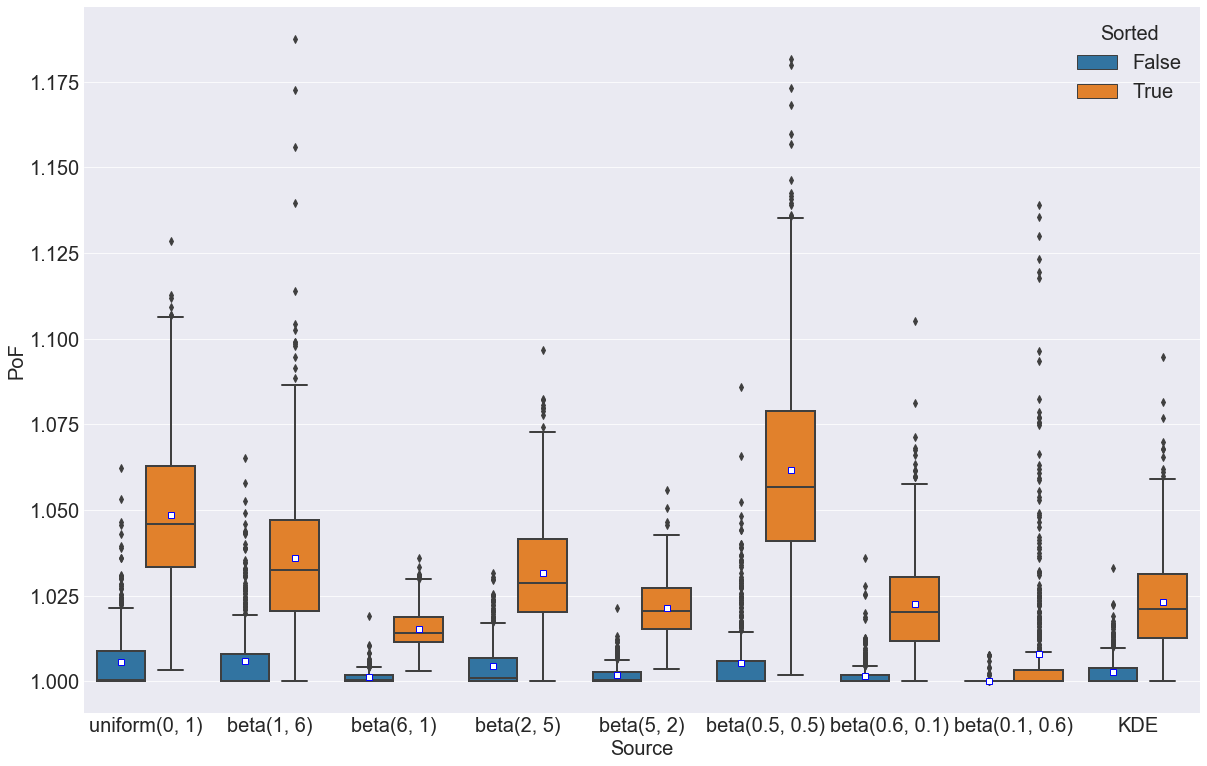

In [34]:
sns.boxplot(
    x='Source', y='PoF', hue='Sorted', data=pof_df,
    showmeans=True, meanprops={"marker": "s","markerfacecolor": "white", "markeredgecolor": "blue"}
)
plt.show()